<a href="https://colab.research.google.com/github/MarwaAli312/StructuredStreaming_Spark/blob/main/SparkStructuredStreaming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spark Structured Streaming  use case:
A bank that wants to automatically verify whether a new transaction may be fraudulent.

* This is a demenstration on how streaming works, and how the pipeline 
analyses each batch of data.

### Configuring Kaggle on Colab

https://www.kaggle.com/docs/api


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marwaali","key":"630a9ad0d2eeb4f710cc57d2049c3bcf"}'}

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/kaggle/

/content/drive/MyDrive/Colab Notebooks/kaggle


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


### Setting up the dataset

https://www.kaggle.com/ntnu-testimon/paysim1

This dataset is interesting because it has a column names step, each unit represents an hour (1 step = 1h )
 - This made it easy to split the dataset into small batches of one unit of time


In [ ]:
!kaggle datasets download -d 'ntnu-testimon/paysim1'

 96% 170M/178M [00:01<00:00, 107MB/s]
100% 178M/178M [00:02<00:00, 89.8MB/s]


In [ ]:
#!sudo apt-get install unzip
!unzip paysim1.zip -d data/

Archive:  paysim1.zip
  inflating: data/PS_20174392719_1491204439457_log.csv  


In [ ]:
!rm -rf paysim1.zip

Saving the dataset under kaggle/data folder, with the name pysim.csv

In [ ]:
!mv data/PS_20174392719_1491204439457_log.csv data/paysim.csv

### Installing PySpark

In [ ]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 72kB/s 
     |████████████████████████████████| 204kB 52.6MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=a43c68993747ea86835119d414665fae8b5b1378ada8bebdeffaa43613d06398
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


https://www.kaggle.com/ntnu-testimon/paysim1

### Preparing the data

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

#creating a spark session
spark = SparkSession.builder.getOrCreate()

In [ ]:
df = spark.read.csv("data/paysim.csv", header=True, inferSchema=True)

In [ ]:
df.columns

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

For our streaming system, we don't know whether the transaction is fraudulent or not
* We just get the data and process it, then thanks to ML algorithms for 
example we can work on classification

In [ ]:
df = df.drop("isFraud", "isFlaggedFraud")

In [ ]:
df.show(2)

+----+-------+-------+-----------+-------------+--------------+-----------+--------------+--------------+
|step|   type| amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|
+----+-------+-------+-----------+-------------+--------------+-----------+--------------+--------------+
|   1|PAYMENT|9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|
|   1|PAYMENT|1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|
+----+-------+-------+-----------+-------------+--------------+-----------+--------------+--------------+
only showing top 2 rows



Step maps a unit of time in the real world. In this case 1 step is 1 hour of time. 
* So we can assume for this example that we have another job that runs every hour and gets all the transactions in that time frame.

To get this task done, we will group the transactions by their timeframe ( step ) 

In [ ]:
df.groupBy("step").count().show(3)

+----+-----+
|step|count|
+----+-----+
| 148|   12|
| 463|   10|
| 471| 2620|
+----+-----+
only showing top 3 rows



We can therefore save the output of that job by filtering on each step and saving it to a separate file:

* We get seperate batches of data, each corresponds to a different  timeframe

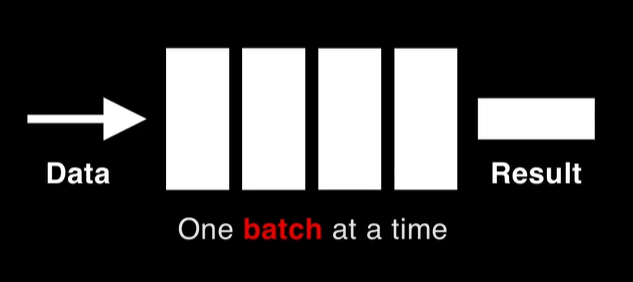

In [ ]:
#%%time
steps = df.select("step").distinct().collect() #collecting the different timeframes or steps
for step in steps[:]:
  _df = df.where(f"step = {step[0]}") #filtering enteries having step=our timeframe
  #by adding coalesce(1) we save the dataframe to one file
  _df.coalesce(1).write.mode("append").option("header", "true").csv("data/paysim") #save it in a folder names paysim under the data folder

The process takes much time so I interrupted it.

We can see the created batches so far:

In [ ]:
!cd data/paysim/ && ls

part-00000-05032df4-6621-4309-a7ff-70cb8bf7c560-c000.csv
part-00000-113abbff-2185-44dc-9b93-b23ed894aa49-c000.csv
part-00000-18358e1f-d4fe-4472-9552-a0f2194a1d92-c000.csv
part-00000-1b5963e5-e748-4d2f-ac19-892c084be061-c000.csv
part-00000-24ac482e-3064-4a2b-bb3c-e3a9269f2b3e-c000.csv
part-00000-30950184-7fbc-42d6-a038-c3ec49ab6faa-c000.csv
part-00000-36b7434a-49e0-40df-aefe-5c1d5e78424e-c000.csv
part-00000-3feb0924-65fb-47a0-8143-54ba3648fcf4-c000.csv
part-00000-40a02697-3461-4845-a8b8-641fe2ec6a30-c000.csv
part-00000-41495f70-16e1-4fda-b0a2-3c7146f032ad-c000.csv
part-00000-444bba9e-4ca2-4793-aeba-05d41b74eed3-c000.csv
part-00000-45d72050-f53e-4871-8f90-258514c384cc-c000.csv
part-00000-56287dca-b501-43dc-9f0f-2ead3c033ef9-c000.csv
part-00000-5c429ce0-0b7e-4165-907a-9f253b3c7da6-c000.csv
part-00000-612d04a3-94a9-4e09-96ad-cbf5af821f9f-c000.csv
part-00000-705a1799-5aef-4946-92f7-e60d318b5f58-c000.csv
part-00000-7165dc02-2708-4def-bb10-8350a8236e24-c000.csv
part-00000-719cf59b-6ba7-4151-8

In [ ]:
part = spark.read.csv(
    "/content/drive/MyDrive/Colab Notebooks/kaggle/data/paysim/part-00000-d399ac30-bb8b-4690-ba9a-decf44787217-c000.csv",
    header=True,
    inferSchema=True,
)

In [ ]:
part.groupBy("step").count().show() 
#one step since we made a seperate file for each step

+----+-----+
|step|count|
+----+-----+
| 137|32559|
+----+-----+



### Structured Streaming

Structured Streaming; Is simply your dataframe, but streaming.

- You treat the stream of data as a table to which data is continiously appended.

- The job itself then checks for new input data, processes it, updates the internal state then updates the result.


---







Let’s create a streaming version of this input, we'll read each file one by one as if it was a stream.

In [ ]:
#get the schema of the stream ( dataframe )
dataSchema = part.schema

In [ ]:
dataSchema

StructType(List(StructField(step,IntegerType,true),StructField(type,StringType,true),StructField(amount,DoubleType,true),StructField(nameOrig,StringType,true),StructField(oldbalanceOrg,DoubleType,true),StructField(newbalanceOrig,DoubleType,true),StructField(nameDest,StringType,true),StructField(oldbalanceDest,DoubleType,true),StructField(newbalanceDest,DoubleType,true)))

*maxFilesPerTrigger* allows you to control how quickly Spark will read all of the files in the folder. 
In this example we're limiting the flow of the stream to one file per trigger.

Simply we will go through all the files one by one


In [ ]:
streaming = (
    spark.readStream.schema(dataSchema)
    .option("maxFilesPerTrigger", 1) #going through the files one by one
    .csv("data/paysim/") #files that exist in data/paysim/
)

Let's set up a transformation on the streamed data.
* In this example we assume that maybe if many transcations are going to the same account, it can be a potential fraud.


The nameDest column is the recipient ID of the transaction.

In [ ]:
dest_count = streaming.groupBy("nameDest").count().orderBy(F.desc("count"))

Now that we have our transformation, we need to specify an output sink for the results. For this example, we're going to write to a memory sink which keeps the results in memory.

We also need to define how Spark will output that data. In this example, we'll use the complete output mode (rewriting all of the keys along with their counts after every trigger).

Here our key is the nameDest

In [ ]:
activityQuery = (
    dest_count.writeStream.queryName("dest_counts")  #write the results from previous cell
    .format("memory") #set the sink to memory
    .outputMode("complete")
    .start()
)

Spark Streaming jobs are continuous applications and in production activityQuery.awaitTermination() is required because it prevents the driver process from terminating when the stream is active (in the background).

If the driver is killed then the application is too therefore killed hence activityQuery.awaitTermination() is sort of like a fail-safe. If you want to turn off the stream in Jupyter you can run activityQuery.stop() to reset a query for testing purposes

In [ ]:
# activityQuery.awaitTermination()

In [ ]:
import time

for x in range(50):
  #search for the destinations having more than two transactions
    _df = spark.sql(
        "SELECT * FROM dest_counts WHERE nameDest != 'nameDest' AND count >= 2"
    )
    #show maximum 10 rows ( just for demonstration purposes )
    if _df.count() > 0:
        _df.show(10)
    time.sleep(0.5)

+-----------+-----+
|   nameDest|count|
+-----------+-----+
| C319921943|    2|
| C803352127|    2|
|C1887077333|    2|
+-----------+-----+

+-----------+-----+
|   nameDest|count|
+-----------+-----+
| C319921943|    2|
| C803352127|    2|
|C1887077333|    2|
+-----------+-----+

+-----------+-----+
|   nameDest|count|
+-----------+-----+
| C319921943|    2|
| C803352127|    2|
|C1887077333|    2|
+-----------+-----+

+-----------+-----+
|   nameDest|count|
+-----------+-----+
| C319921943|    2|
| C803352127|    2|
|C1887077333|    2|
| C763794011|    2|
| C488343370|    2|
+-----------+-----+

+-----------+-----+
|   nameDest|count|
+-----------+-----+
| C319921943|    2|
| C803352127|    2|
|C1887077333|    2|
| C763794011|    2|
| C488343370|    2|
+-----------+-----+

+-----------+-----+
|   nameDest|count|
+-----------+-----+
| C319921943|    2|
| C803352127|    2|
|C1887077333|    2|
| C763794011|    2|
| C488343370|    2|
+-----------+-----+

+-----------+-----+
|   nameDest|c

Check if stream is active

In [ ]:
spark.streams.active[0].isActive

True

In [ ]:
activityQuery.status

{'isDataAvailable': True,
 'isTriggerActive': True,
 'message': 'Processing new data'}

If we  want to turn off the stream we'll run activityQuery.stop() to reset the query for testing purposes.

In [ ]:
activityQuery.stop()